In [ ]:
import os
from google.colab import files
import copy
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch.utils.data import TensorDataset

import tensorflow as tf

from tensorflow import keras
import pickle

import seaborn as sns
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import copy

import sklearn
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning

from sklearn.utils import check_random_state


In [ ]:
def make_sparse_coded_signal1(n_samples, *, n_components, n_features,
                             n_nonzero_coefs, random_state=None):
    """Generate a signal as a sparse combination of dictionary elements.
    Returns a matrix Y = DX, such as D is (n_features, n_components),
    X is (n_components, n_samples) and each column of X has exactly
    n_nonzero_coefs non-zero elements.
    Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    n_components : int
        Number of components in the dictionary
    n_features : int
        Number of features of the dataset to generate
    n_nonzero_coefs : int
        Number of active (non-zero) coefficients in each sample
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    data : ndarray of shape (n_features, n_samples)
        The encoded signal (Y).
    dictionary : ndarray of shape (n_features, n_components)
        The dictionary with normalized components (D).
    code : ndarray of shape (n_components, n_samples)
        The sparse code such that each column of this matrix has exactly
        n_nonzero_coefs non-zero items (X).
    """
    generator = check_random_state(random_state)

    # generate dictionary
    D = generator.randn(n_features, n_components)
    D /= np.sqrt(np.sum((D ** 2), axis=0)) 

    #D=perm_free(D)


    # generate code
    X = np.zeros((n_components, n_samples))



    for i in range(n_samples):
        idx = np.arange(n_components)
        generator.shuffle(idx)
        idx = idx[:n_nonzero_coefs]
        X[idx, i] = generator.randn(n_nonzero_coefs)


    (D,X)=perm_free_DS(D,X)

    # encode signal
    Y = np.dot(D, X)

    return map(np.squeeze, (Y, D, X))


In [ ]:
def perm_free(D):
    #return D
    D=D
    for i in range(D.shape[1]):
        #print(np.sign( np.sum(D[i,:]) ))
        D[:,i]*=np.sign( np.sum(D[:,i]) )

    col_sums=[np.sum(D[:,i]) for i in range(D.shape[1])]
    idx=list(range(D.shape[1]))
    new_idx=np.argsort(col_sums)[::-1]
    D_new=D[:,new_idx]
    
    return D_new

In [ ]:
# ax=[2,1,3,4]
# idx=np.argsort(ax)[::-1]
# ls=[ax[el] for el in idx]
# print(ls)

In [ ]:
def perm_free_DS(D, code):
    #return (D,code)
    #D=D
    for i in range(D.shape[1]):
        #print(np.sign( np.sum(D[i,:]) ))
        D[:,i]*=np.sign( np.sum(D[:,i]) )

    col_sums=[np.sum(D[:,i]) for i in range(D.shape[1])]
    idx=list(range(D.shape[1]))
    #print('idx',idx)
    new_idx=np.argsort(col_sums)[::-1]

    #print('new_idx',new_idx)
    D_new=D[:,new_idx]

    code=code[new_idx,:]
    
    return (D_new, code)

In [ ]:
n_nonzero_coefs=10

n_comp=15

##### Default #######
# X, dictionary, code = make_sparse_coded_signal(
# n_samples=10, n_components=n_comp, n_features=20, n_nonzero_coefs=n_nonzero_coefs,random_state=42,
# )

####### custom #######
X, dictionary, code = make_sparse_coded_signal1(
n_samples=200, n_components=n_comp, n_features=20, n_nonzero_coefs=n_nonzero_coefs,random_state=42,
)


In [ ]:
# (dictionary, code)=perm_free_DS(dictionary, code)
# X=dictionary.dot(code)

In [ ]:
dictionary.shape

(20, 15)

In [ ]:
# n_nonzero_coefs=10

# n_comp=15

# X, dictionary, code = make_sparse_coded_signal(
# n_samples=100, n_components=n_comp, n_features=20, n_nonzero_coefs=n_nonzero_coefs,random_state=42,
# )


In [ ]:

# print(X.shape)
# print(dictionary.shape)
# print(code.shape)

Idea (by Anirvan): Feed in the X that we obtain here into an autoencoder. 

# Dictionary learning

In [ ]:
##alpha=1 (regularization parameter)
dict_learner = DictionaryLearning(n_components=n_comp, transform_algorithm='lasso_lars'\
                                  , max_iter=1000, random_state=42)
X_transformed = dict_learner.fit_transform(X)

In [ ]:
#X_transformed=perm_free(X_transformed)

(X_transformed, dict_learner.components_) = \
perm_free_DS(X_transformed, dict_learner.components_)

#(dictionary,code)=perm_free_DS(dictionary,code)

X=dictionary.dot(code)

print(X.shape)
print(X_transformed.shape)

(20, 200)
(20, 15)


In [ ]:
print('Y=DX')
print(' Y:', X.shape)
print('Dictionary called D:',dictionary.shape)
print('Code (called X):',code.shape)
print( 'Code  has %d n_non_zero coefficients'%n_nonzero_coefs )

Y=DX
 Y: (20, 200)
Dictionary called D: (20, 15)
Code (called X): (15, 200)
Code  has 10 n_non_zero coefficients


In [ ]:
## Fraction of zero elements. 
np.mean(X_transformed == 0)

0.8433333333333334

In [ ]:
X_hat = X_transformed @ dict_learner.components_

Compare the average squared euclidean norm of the reconstruction error of the sparse coded signal relative to the squared euclidean norm of the original signal

In [ ]:
print( np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)) )

#print( X_transformed.shape )
print( np.linalg.norm(X_transformed-dictionary)/np.linalg.norm(dictionary) )
print( np.linalg.norm(X_transformed-dictionary))
#/np.linalg.norm(dictionary) )


#print( np.linalg.norm(X_transformed-dictionary)/np.linalg.norm(dictionary) )

1.486741006109072
9.873820131887687
38.24114093424853


In [ ]:
dictionary.shape
print( np.linalg.norm(dictionary) )
print( np.linalg.norm(X_transformed)  )

3.872983346207416
39.21815758322915


($U^*,V^*$) = argmin 0.5 $|| X - U V ||_2^2$ + $\alpha * || U ||_1$
            (U,V)
            with $|| V_k ||_2$ = 1 for all  0 <= k < n_components


In [ ]:
print( 'tranformed_shape',X_transformed.shape)
print('Dict_learner_comp shape',dict_learner.components_.shape)
print('New_data (Yhat)',X_hat.shape)

tranformed_shape (20, 15)
Dict_learner_comp shape (15, 200)
New_data (Yhat) (20, 200)


Here the X is the X we give in, U is the transformed thingy that is sparse 
Similar to D, V has its columns normailized
i.e. for all  0 <= k < n_components (15 here), we have || V_k ||_2 = 1.

(Check further into UV and the @)

In [ ]:
print(X_hat)

[[-0.6690995  -0.43704867 -0.0971785  ... -0.08344298 -0.62343596
   0.78368503]
 [ 0.43601838  0.66749652 -0.54418303 ...  0.75374062 -0.489587
   0.75159501]
 [ 0.08996093  1.33377834  0.32897132 ... -0.56041116  0.10561624
  -0.96749547]
 ...
 [-0.53267719  0.3615614  -0.28486973 ...  0.36075823  0.36124715
  -0.60614299]
 [ 0.75591906 -1.01443117  0.33791437 ...  0.34439684  0.77595975
   0.11748738]
 [ 0.4035342   0.35350406  0.08820177 ...  0.44340633  0.33752361
  -0.61456497]]


# Playing with params



In [ ]:
# n_components1=20
# n_nonzero_coefs1=10
# n_samples1=200

# n_features1=40

# #make_sparse_coded_signal1 if with perm_free transform
# X1, dictionary1, code1 = make_sparse_coded_signal1(
# n_samples=n_samples1, n_components=n_components1, n_features=n_features1, n_nonzero_coefs=n_nonzero_coefs1,random_state=42,
# )


# ##alpha=1 (regularization parameter)
# ## When making alpha smaller, the error is growing

# dict_learner = DictionaryLearning(n_components=n_components1, transform_algorithm='lasso_lars'\
#                                   , random_state=42, alpha=0.1 )

# X_transformed1 = dict_learner.fit_transform(X1)
# X_transformed1 = perm_free(X_transformed1)


# X_hat1 = X_transformed1 @ dict_learner.components_


# np.mean(np.sum((X_hat1 - X1) ** 2, axis=1) / np.sum(X1 ** 2, axis=1))

In [ ]:
#reg_params_list=[1,0.1,0.01, 0.001, 0.0001]
reg_params_list=[1, 0.001]

n_components_list=list(range(10,20,2))
#list(range(10,40,10))
n_features1=20

n_nonzero_coefs1=10
n_samples1=200

dct_Xhat1 = {k:[] for k in reg_params_list}
X1_dict={k:[] for k in reg_params_list}

error_dct={k:[] for k in reg_params_list}
error_ratio_dct={k:[] for k in reg_params_list}

error_dict_dct={k:[] for k in reg_params_list}
error_code_dct={k:[] for k in reg_params_list}

In [ ]:
type(error_dct)

dict

In [ ]:
n_components_list
# np.save('comp',n_components_list)

[10, 12, 14, 16, 18]

In [ ]:
for reg_param in reg_params_list:
  for n_components1 in n_components_list:

    #make_sparse_coded_signal1 if with perm_free transform
    X1, dictionary1, code1 = make_sparse_coded_signal1(
    n_samples=n_samples1, n_components=n_components1, n_features=n_features1, \
    n_nonzero_coefs=n_nonzero_coefs1,random_state=42,
    )

    ### Permuting all 3 quant both
    (dictionary1, code1)=perm_free_DS(dictionary1, code1)
    X1=dictionary1.dot(code1)
    ### Permuting all 3 in order to make an invariant version


    ##alpha=1 (regularization parameter)
    ## When making alpha smaller, the error is growing

    dict_learner = DictionaryLearning(n_components=n_components1,\
                                      transform_algorithm='lasso_lars'\
                                      , random_state=42, alpha=reg_param )

    X_transformed1 = dict_learner.fit_transform(X1)
    
    #(X_transformed1, dict_learner.components_) = \
    #perm_free_DS(X_transformed1, dict_learner.components_)
    
    
    #X_transformed1 = perm_free(X_transformed1)
    #dict_learner.components_=perm_free(dict_learner.components_)


    X_hat1 = X_transformed1 @ dict_learner.components_

    dct_Xhat1[reg_param].append(X_hat1) 

    X1_dict[reg_param].append(X1)

    error=np.mean(np.sum((X_hat1 - X1) ** 2, axis=1)/np.sum(X1 ** 2, axis=1)) 

    #error_ratio=np.mean(np.sum((X_hat1 - X1) ** 2, axis=1) / np.sum(X1 ** 2, axis=1))

    error_dct[reg_param].append(error)

    print(r'Avg ||\hat{X}-X||^{2}_2',error)

    error_inD=np.linalg.norm((X_transformed1 - dictionary1))/np.linalg.norm(dictionary1)
    
    print(r'Avg ||\hat{D}-D||^{2}_F',error_inD)

    error_dict_dct[reg_param].append(error_inD)
                    
    error_in_sparse=np.mean(np.sum((dict_learner.components_ - code1) ** 2,\
                                   axis=1)/np.sum(code1 ** 2, axis=1))

    error_code_dct[reg_param].append(error_in_sparse)
    print('Relative sparse error', error_in_sparse)


Avg ||\hat{X}-X||^{2}_2 0.060372407068467894
Avg ||\hat{D}-D||^{2}_F 12.270224001764895
Relative sparse error 1.0287504085655235
Avg ||\hat{X}-X||^{2}_2 0.061445329806555406
Avg ||\hat{D}-D||^{2}_F 11.3427758176411
Relative sparse error 1.00721572339595
Avg ||\hat{X}-X||^{2}_2 0.050003822088497664
Avg ||\hat{D}-D||^{2}_F 10.708232045750945
Relative sparse error 1.0179842625720945
Avg ||\hat{X}-X||^{2}_2 0.0465555776026398
Avg ||\hat{D}-D||^{2}_F 9.874753611112107
Relative sparse error 1.007720306517197
Avg ||\hat{X}-X||^{2}_2 0.040507222114660936
Avg ||\hat{D}-D||^{2}_F 9.30696957039188
Relative sparse error 1.009627835533662
Avg ||\hat{X}-X||^{2}_2 0.07749530591771422
Avg ||\hat{D}-D||^{2}_F 11.706979071259607
Relative sparse error 1.0240445086462788
Avg ||\hat{X}-X||^{2}_2 0.0908450788441432
Avg ||\hat{D}-D||^{2}_F 10.25776132955704
Relative sparse error 1.0006630505464524
Avg ||\hat{X}-X||^{2}_2 0.0834663269714328
Avg ||\hat{D}-D||^{2}_F 9.868209651074846
Relative sparse error 1.024

In [ ]:
np.save("error_dct",error_dct)

np.save("error_dict_dict",error_dict_dct)

np.save("error_code_dct" ,error_code_dct)

files.download("error_dct.npy")

files.download("error_dict_dict.npy")

files.download("error_code_dct.npy")





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
error_dct2=np.load("error_dct.npy", allow_pickle=True)[()] 

error_dict_dct=np.load("error_dict_dict.npy", allow_pickle=True)[()] 

## Creates a food dct type

In [ ]:
error_dct
#len(error_dct[1])

{0.0001: [1.2531037847439328,
  1.4686415243883488,
  1.7184563227459488,
  1.7574421010728216,
  1.391777128935036],
 0.001: [1.2076477630136078,
  1.4666124877995779,
  1.7135787579794362,
  1.6340980964374263,
  1.3425767586287294],
 0.01: [1.6293728128950633,
  1.9309533863459678,
  1.6001463066734298,
  1.8319007821093822,
  1.4027045129355034],
 0.1: [1.3448308658263488,
  1.4689937968841522,
  1.8285027557034605,
  1.7747723079174034,
  1.5729091762739824],
 1: [1.6039205016463494,
  1.6410176100675389,
  1.5149924124779874,
  1.7553021188897469,
  1.7482816989557797]}

In [ ]:
error_dct1={0.0001: [0.08545431981614603,
  0.09925559600647983,
  0.10065065216912868,
  0.11073269004818384,
  0.1290320595140234],
 0.001: [0.07749530591771422,
  0.0908450788441432,
  0.0834663269714328,
  0.0925130171089681,
  0.10519447164896523],    
  0.01: [0.059864694904619355,
  0.06418184877719113,
  0.056222979271057516,
  0.05115586745867963,
  0.0505611296918177],
 0.1: [0.05433241154327727,
  0.04946950377455229,
  0.048945723199539964,
  0.03927800474054877,
  0.026184420525214348],
 1: [0.060372407068467894,
  0.061445329806555406,
  0.050003822088497664,
  0.0465555776026398,
  0.040507222114660936]}

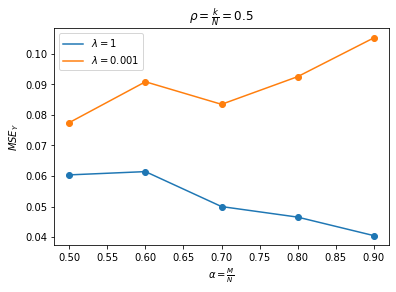

In [ ]:
import matplotlib.pyplot as plt
x=n_components_list

for reg_p in reg_params_list:
  plt.scatter(np.array(x)/20,error_dct[reg_p])
  plt.plot(np.array(x)/20,error_dct[reg_p], label=r'$\lambda=$'+ str(reg_p))
  #plt.label(r'$\lambda=$'+ str(reg_param))

plt.ylabel(r"$MSE_{Y}$")
plt.xlabel(r'$\alpha=\frac{M}{N}$')
plt.title(r'$\rho=\frac{k}{N}=0.5$')

plt.legend()

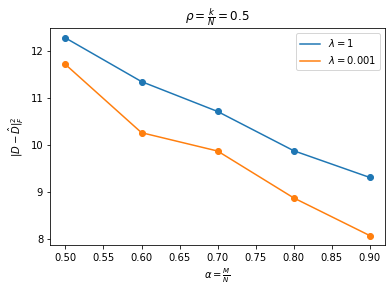

In [ ]:
import matplotlib.pyplot as plt
x=n_components_list

for reg_p in reg_params_list:
  plt.scatter(np.array(x)/20,error_dict_dct[reg_p])
  plt.plot(np.array(x)/20,error_dict_dct[reg_p], label=r'$\lambda=$'+ str(reg_p))
  #plt.label(r'$\lambda=$'+ str(reg_param))

plt.ylabel(r"$|D-\hat{D}|^{2}_{F}$")
plt.xlabel(r'$\alpha=\frac{M}{N}$')
plt.title(r'$\rho=\frac{k}{N}=0.5$')

plt.legend()

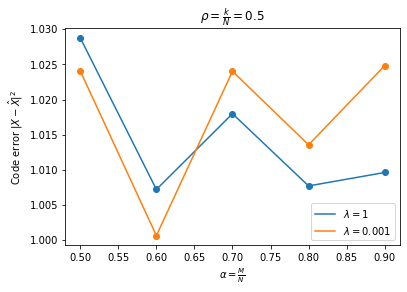

In [ ]:
import matplotlib.pyplot as plt
x=n_components_list

for reg_p in reg_params_list:
  plt.scatter(np.array(x)/20,error_code_dct[reg_p])
  plt.plot(np.array(x)/20,error_code_dct[reg_p], label=r'$\lambda=$'+ str(reg_p))
  #plt.label(r'$\lambda=$'+ str(reg_param))

plt.ylabel(r"Code error $|{X-\hat{X}}|^{2}$")
plt.xlabel(r'$\alpha=\frac{M}{N}$')
plt.title(r'$\rho=\frac{k}{N}=0.5$')

plt.legend()

In [ ]:
import matplotlib.pyplot as plt
x=n_components_list

for reg_p in [1,0.1,0.01,0.001,0.0001]:
  plt.scatter(np.array(x)/20,error_dct1[reg_p])
  plt.plot(np.array(x)/20,error_dct1[reg_p], label=r'$\lambda=$'+ str(reg_p))
  #plt.label(r'$\lambda=$'+ str(reg_param))

plt.ylabel("MSE")
plt.xlabel(r'$\alpha=\frac{M}{N}$')
plt.title(r'$\rho=\frac{k}{N}=0.5$')

plt.legend()

In [ ]:
'''
## N_samples=200, reg_params_list=[1,0.1,0.01]
n_components_list=list(range(10,40,10))
n_features1=40
n_nonzero_coefs1=10
n_samples1=200
'''
{0.01: [0.13604045016346394, 0.17480854277158006, 0.1500905956229753],
 0.1: [0.12522975684416987, 0.14726443443070383, 0.11362646669162765],
 1: [0.1385648262817517, 0.18828913224802568, 0.12298650206928159]}

 ## Note with 35 comp however, the error is significantly low

 ## Plausible explanation: many permutations are valid: But if its too high
 ## There aren't a lot of valid perms , thus lower error

{0.01: [0.13604045016346394, 0.17480854277158006, 0.1500905956229753],
 0.1: [0.12522975684416987, 0.14726443443070383, 0.11362646669162765],
 1: [0.1385648262817517, 0.18828913224802568, 0.12298650206928159]}

In [ ]:
np.mean(np.sum((X_hat1 - X1) ** 2, axis=1) / np.sum(X1 ** 2, axis=1))

0.08181262583176811

# Feeding into autoencoder

Define trainloader using costum dataset

In [ ]:
BatchSize = 100
#trainset=X
n_samples=100

my_x=list(X.reshape(n_samples,input_dim,-1))
tensor_x = torch.Tensor(my_x) # transform to torch tensor
#tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x) # create your datset
#trainloader = DataLoader(my_dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                         shuffle=True, num_workers=2)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
#                                          shuffle=True, num_workers=2)

In [ ]:
my_x[0].shape
print(type(my_x[0]))

<class 'numpy.ndarray'>


In [ ]:
import torch
import torch.nn as nn



## takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)


class Autoencoder(nn.Module):
    def __init__(self,width, input_dim):


        super(Autoencoder, self).__init__()


        #N 784 (28 by 28)
        n=width # number of internal nodes
        self.encoder =nn.Sequential(
            nn.Linear(input_dim, n),
            #nn.Linear(28*28, 128),
            nn.Tanh() 
            #nn.ReLU(),
        )
        self.decoder =nn.Sequential(
            nn.Linear(n, input_dim), # 3 -> N, 784
            ## Another activation function
            nn.Sigmoid() #if 0 to 1 
            #nn.Tanh() #if -1 to 1
        )

    def forward(self,x):
        x = self.encoder(x)        
        x = self.decoder(x)
        return x

    
#Note:[-1,1] -> Apply tanh
## Normalization


width=15

input_dim=20
net = Autoencoder(width, input_dim)

#net = net.float()
#net = net.double()


'''
 Two different kind of initialization 
Since we will work with single layer type architecture\
 using glorot-like architecture isn't necessary

'''
#net.apply(init_weights)

#net.apply(weights_init_normal)

print(net)

## Making this change to accomodate double
#net = net.double()

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=15, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=20, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = (model_children[i](values))
        loss += torch.mean(torch.abs(values))
    return loss

In [ ]:
iterations=50
num_epochs=iterations

#reg_param = 0.01 # sparsity factor

reg_param =1.0


#reg="0"
#reg="1e-2"



width_list=[25]



#width_list=[10,50,100,400,1000]

#width_list=[10,100,1000,10000,50000,100000]

#width_list

criterion=nn.MSELoss()

#optimizer= torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

list_init_weightE=[]
list_init_weightD=[]
# init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
# init_weightsD = copy.deepcopy(net.decoder[0].weight.data)


In [ ]:
for width in width_list:

  model = Autoencoder(width, input_dim)
  #net = net.float()
  #net = net.double()


  init_weightsE = copy.deepcopy(model.encoder[0].weight.data)
  init_weightsD = copy.deepcopy(model.decoder[0].weight.data)

  list_init_weightE.append(init_weightsE )
  list_init_weightD.append(list_init_weightD)

  model_children = list(model.children())


  optimizer= torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)

  for epoch in range(iterations):  # loop over the dataset multiple times
      runningLoss = 0.0
      model.train()
      #for data in trainloader:
          

      for img in trainloader:
        # get the inputs
        img=img.float()
        img=img.reshape(-1,input_dim)#.double() 
        
        #print(img.shape, recon.shape)
        recon=model(img)

        #loss= criterion(recon, img)
        mse_loss= criterion(recon, img)
        loss = mse_loss + reg_param * sparse_loss(model, img)

        optimizer.zero_grad() # zeroes the gradient buffers of all parameters

        loss.backward()

        optimizer.step()

      print(f'At epoch: {epoch+1}/{iterations}, ; Loss:{loss.item():.4f}')
      
      #### Saving checkpoint ###
      '''
      checkpoint={'state_dict': model.state_dict(), 'optinizer':optimizer.state_dict()}
      filename="model_1e-2reg"+str(width)
      save_checkpoint(checkpoint, filename)
      '''

  #reg="0"
  #reg="1e-2"

  #PATH="/content/MyDrive/My Drive/Auto_An/Checkpoints/"+reg+str(width)
  #torch.save(model, PATH)
                                                            
      
  print('Finished Training with width %d'%(width))



At epoch: 1/50, ; Loss:1.6609
At epoch: 2/50, ; Loss:1.4267
At epoch: 3/50, ; Loss:1.2307
At epoch: 4/50, ; Loss:1.0287
At epoch: 5/50, ; Loss:0.9039
At epoch: 6/50, ; Loss:0.8648
At epoch: 7/50, ; Loss:0.8572
At epoch: 8/50, ; Loss:0.8503
At epoch: 9/50, ; Loss:0.8366
At epoch: 10/50, ; Loss:0.8168
At epoch: 11/50, ; Loss:0.7992
At epoch: 12/50, ; Loss:0.7822
At epoch: 13/50, ; Loss:0.7633
At epoch: 14/50, ; Loss:0.7453
At epoch: 15/50, ; Loss:0.7297
At epoch: 16/50, ; Loss:0.7184
At epoch: 17/50, ; Loss:0.7115
At epoch: 18/50, ; Loss:0.7020
At epoch: 19/50, ; Loss:0.6920
At epoch: 20/50, ; Loss:0.6832
At epoch: 21/50, ; Loss:0.6770
At epoch: 22/50, ; Loss:0.6698
At epoch: 23/50, ; Loss:0.6659
At epoch: 24/50, ; Loss:0.6604
At epoch: 25/50, ; Loss:0.6556
At epoch: 26/50, ; Loss:0.6507
At epoch: 27/50, ; Loss:0.6468
At epoch: 28/50, ; Loss:0.6433
At epoch: 29/50, ; Loss:0.6390
At epoch: 30/50, ; Loss:0.6342
At epoch: 31/50, ; Loss:0.6304
At epoch: 32/50, ; Loss:0.6299
At epoch: 33/50, 

In [ ]:
recon_list=[]
for (img) in trainloader:
  # get the inputs
  img=img.float()
  img=img.reshape(-1,input_dim)#.double() 
  
  #print(img.shape)
  recon=model(img)
  recon_list.append(recon)


In [ ]:
X_auto=recon_list[0].reshape(input_dim,-1).detach().numpy()

In [ ]:
len(recon_list)

1

In [ ]:
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.07501460628373915

In [ ]:
X.shape

(20, 100)

In [ ]:
print('Distance from X',np.mean(np.sum((X_auto - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))
print('Distance from X_hat',np.mean(np.sum((X_auto - X_hat) ** 2, axis=1) / np.sum(X ** 2, axis=1)))


Distance from X 1.001753039857144
Distance from X_hat 0.6690740819489844


Width of Autoenc=15 (same as components)

With no regularization <br>
Distance from X 1.3123950827266693
Distance from X_hat 0.9773240026539556

With egularization=1.0 <br>
Distance from X 1.0048371869391701
Distance from X_hat 0.6716589080743648

In [ ]:
print('Distance from X',np.mean(np.sum((X_auto - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))
print('Distance from X_hat',np.mean(np.sum((X_auto - X_hat) ** 2, axis=1) / np.sum(X ** 2, axis=1)))


Distance from X 1.3123950827266693
Distance from X_hat 0.9773240026539556


In [ ]:
## Boundary condition
np.mean(np.sum((X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

1.0